In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import os

# Apuntar EXPLÍCITAMENTE a la licencia (OneDrive)
os.environ["GRB_LICENSE_FILE"] = r"C:\Users\PC2\OneDrive\Desktop\gurobi.lic"

print("GRB_LICENSE_FILE =", os.environ["GRB_LICENSE_FILE"])
import gurobipy as gp
print("Gurobi version:", gp.gurobi.version())

GRB_LICENSE_FILE = C:\Users\PC2\OneDrive\Desktop\gurobi.lic
Gurobi version: (13, 0, 0)


## Foward problem y generacion de D



In [3]:
from gurobipy import GRB


def solve_original_lp(c, A, b, output=0):
    m = gp.Model("original_lp")
    m.Params.OutputFlag = output

    n = len(c)
    m_con = len(b)

    x = m.addVars(n, lb=0.0, name="x")
    m.setObjective(gp.quicksum(c[j] * x[j] for j in range(n)), GRB.MINIMIZE)

    for i in range(m_con):
        m.addConstr(gp.quicksum(A[i][j] * x[j] for j in range(n)) >= b[i], name=f"con_{i}")

    m.optimize()
    if m.Status != GRB.OPTIMAL:
        raise RuntimeError(f"Original LP not optimal. Status={m.Status}")

    x_hat = [x[j].X for j in range(n)]
    z_hat = m.ObjVal
    return x_hat, z_hat

In [4]:

def apply_favorable_property(modelF, xF, property_list, other_params=None):
    """
    Simplified context:
      - xF is a 1D gurobi variable container: xF[j] for j = 0..n-1
      - property_list is a list of dicts describing linear properties on x
      - other_params can contain x_hat, n, etc. if needed

    Supported property types (examples):
      - {"type":"x_ge", "idx":0, "rhs":2.0}
      - {"type":"x_le", "idx":1, "rhs":3.5}
      - {"type":"sum_ge", "idxs":[0,1], "rhs":7.0}
      - {"type":"sum_le", "idxs":[0,1], "rhs":10.0}
      - {"type":"custom", "expr": lambda m,x,params: ... }
    """
    if other_params is None:
        other_params = {}

    if not isinstance(property_list, list):
        property_list = [property_list]

    for k, prop in enumerate(property_list):
        tp = prop["type"]

        # ---------------------------------------------------------
        # Property: x[idx] >= rhs
        # ---------------------------------------------------------
        if tp == "x_ge":
            idx = int(prop["idx"])
            rhs = float(prop["rhs"])
            modelF.addConstr(xF[idx] >= rhs, name=f"prop_x_ge[{k},{idx}]")

        # ---------------------------------------------------------
        # Property: x[idx] <= rhs
        # ---------------------------------------------------------
        elif tp == "x_le":
            idx = int(prop["idx"])
            rhs = float(prop["rhs"])
            modelF.addConstr(xF[idx] <= rhs, name=f"prop_x_le[{k},{idx}]")

        # ---------------------------------------------------------
        # Property: sum_{j in idxs} x[j] >= rhs
        # ---------------------------------------------------------
        elif tp == "sum_ge":
            idxs = [int(i) for i in prop["idxs"]]
            rhs  = float(prop["rhs"])
            modelF.addConstr(gp.quicksum(xF[j] for j in idxs) >= rhs, name=f"prop_sum_ge[{k}]")

        # ---------------------------------------------------------
        # Property: sum_{j in idxs} x[j] <= rhs
        # ---------------------------------------------------------
        elif tp == "sum_le":
            idxs = [int(i) for i in prop["idxs"]]
            rhs  = float(prop["rhs"])
            modelF.addConstr(gp.quicksum(xF[j] for j in idxs) <= rhs, name=f"prop_sum_le[{k}]")

        # ---------------------------------------------------------
        # Custom user hook
        # ---------------------------------------------------------
        elif tp == "custom":
            # expr signature: expr(modelF, xF, other_params)
            prop["expr"](modelF, xF, other_params)

        else:
            raise ValueError(f"Unknown prop type: {tp}")

In [5]:
def print_vector(name, v, max_len=10, prec=4):
    print(f"{name} (len={len(v)}):")
    if len(v) <= max_len:
        print(" ", [round(x, prec) for x in v])
    else:
        print(" ", [round(x, prec) for x in v[:max_len]], "...")

def print_matrix(name, M, max_rows=6, max_cols=6, prec=4):
    m = len(M)
    n = len(M[0])
    print(f"{name} (shape={m}x{n}):")
    for i in range(min(m, max_rows)):
        row = M[i][:max_cols]
        print(" ", [round(x, prec) for x in row], ("..." if n > max_cols else ""))
    if m > max_rows:
        print("  ...")

## Todo mutable

In [6]:
def add_abs_dev_1d(m, v, vhat, name):
    d = m.addVars(len(vhat), lb=0.0, name=f"d_{name}")
    for i in range(len(vhat)):
        m.addConstr(d[i] >=  v[i] - vhat[i], name=f"abs_pos_{name}[{i}]")
        m.addConstr(d[i] >= -(v[i] - vhat[i]), name=f"abs_neg_{name}[{i}]")
    return d

def add_abs_dev_2d(m, V, Vhat, name):
    m_con = len(Vhat); n = len(Vhat[0])
    d = m.addVars(m_con, n, lb=0.0, name=f"d_{name}")
    for i in range(m_con):
        for j in range(n):
            m.addConstr(d[i,j] >=  V[i,j] - Vhat[i][j], name=f"abs_pos_{name}[{i},{j}]")
            m.addConstr(d[i,j] >= -(V[i,j] - Vhat[i][j]), name=f"abs_neg_{name}[{i},{j}]")
    return d


In [7]:
def solve_wcep_bilinear(
    c_hat, A_hat, b_hat,
    c_bounds, A_bounds, b_bounds,
    property_list,
    other_params=None,
    output=1
):
    """
    WCEP' (Teorema 19): inf_{x,y,c,A,b} δ((c,A,b),(ĉ,Â, b̂))
      s.t. c^T x <= b^T y
           A^T y <= c
           A x   >= b
           x in D(x_hat)
           (c,A,b) in H
           x,y >= 0

    δ: L1 por defecto: ||c-c_hat||_1 + ||A-A_hat||_1 + ||b-b_hat||_1
    """
    if other_params is None:
        other_params = {}

    m_con = len(b_hat)
    n = len(c_hat)

    m = gp.Model("WCEP_bilinear")
    m.Params.OutputFlag = output

    # IMPORTANTE: problema no convexo por bilinearidades
    # Gurobi requiere habilitar NonConvex=2 para resolverlo
    m.Params.NonConvex = 2

    # Variables
    x = m.addVars(n, lb=0.0, name="x")
    y = m.addVars(m_con, lb=0.0, name="y")

    c = m.addVars(n, lb=-GRB.INFINITY, name="c")
    b = m.addVars(m_con, lb=-GRB.INFINITY, name="b")
    A = m.addVars(m_con, n, lb=-GRB.INFINITY, name="A")

    # Bounds de H (c,A,b)
    for j in range(n):
        clo, chi = c_bounds[j]
        m.addConstr(c[j] >= clo, name=f"c_lo[{j}]")
        m.addConstr(c[j] <= chi, name=f"c_hi[{j}]")

    for i in range(m_con):
        blo, bhi = b_bounds[i]
        m.addConstr(b[i] >= blo, name=f"b_lo[{i}]")
        m.addConstr(b[i] <= bhi, name=f"b_hi[{i}]")

    for i in range(m_con):
        for j in range(n):
            Alo, Ahi = A_bounds[i][j]
            m.addConstr(A[i,j] >= Alo, name=f"A_lo[{i},{j}]")
            m.addConstr(A[i,j] <= Ahi, name=f"A_hi[{i},{j}]")

    # Foils: x in D(x_hat)
    apply_favorable_property(m, x, property_list=property_list, other_params=other_params)

    # --- Restricciones WCEP' (14b)-(14d) ---
    # (14b)  c^T x <= b^T y   (bilinear)
    m.addConstr(
        gp.quicksum(c[j] * x[j] for j in range(n)) <= gp.quicksum(b[i] * y[i] for i in range(m_con)),
        name="strong_duality_ineq"
    )

    # (14c)  A^T y <= c  (bilinear)
    for j in range(n):
        m.addConstr(
            gp.quicksum(A[i,j] * y[i] for i in range(m_con)) <= c[j],
            name=f"dual_feas[{j}]"
        )

    # (14d)  A x >= b  (bilinear)
    for i in range(m_con):
        m.addConstr(
            gp.quicksum(A[i,j] * x[j] for j in range(n)) >= b[i],
            name=f"primal_feas[{i}]"
        )

    # Objetivo δ((c,A,b),(ĉ,Â,b̂)) en L1
    dc = add_abs_dev_1d(m, c, c_hat, "c")
    db = add_abs_dev_1d(m, b, b_hat, "b")
    dA = add_abs_dev_2d(m, A, A_hat, "A")

    m.setObjective(
        gp.quicksum(dc[j] for j in range(n)) +
        gp.quicksum(db[i] for i in range(m_con)) +
        gp.quicksum(dA[i,j] for i in range(m_con) for j in range(n)),
        GRB.MINIMIZE
    )

    # (Opcional pero útil) warm-start en el punto factual
    for j in range(n):
        c[j].Start = c_hat[j]
        x[j].Start = 1.0
    for i in range(m_con):
        b[i].Start = b_hat[i]
        y[i].Start = 1.0
        for j in range(n):
            A[i,j].Start = A_hat[i][j]

    m.optimize()
    if m.Status not in (GRB.OPTIMAL, GRB.SUBOPTIMAL):
        raise RuntimeError(f"WCEP' not solved. Status={m.Status}")

    sol = {
        "x": [x[j].X for j in range(n)],
        "y": [y[i].X for i in range(m_con)],
        "c": [c[j].X for j in range(n)],
        "b": [b[i].X for i in range(m_con)],
        "A": [[A[i,j].X for j in range(n)] for i in range(m_con)],
        "obj": m.ObjVal,
        "status": m.Status
    }
    return sol


In [8]:

def solve_lp_value(c, A, b, property_list=None, other_params=None, output=0):
    """
    Resuelve:  min c^T x
              s.t. A x >= b
                   x >= 0
                   (y opcionalmente) x in D(x_hat) via foils
    Retorna (status, obj_value, x_sol)
    """
    if other_params is None:
        other_params = {}

    m_con = len(b)
    n = len(c)

    m = gp.Model("lp_value")
    m.Params.OutputFlag = output

    x = m.addVars(n, lb=0.0, name="x")
    m.setObjective(gp.quicksum(c[j] * x[j] for j in range(n)), GRB.MINIMIZE)

    for i in range(m_con):
        m.addConstr(gp.quicksum(A[i][j] * x[j] for j in range(n)) >= b[i], name=f"feas_{i}")

    if property_list is not None:
        # Usa tu misma función de foils
        apply_favorable_property(m, x, property_list=property_list, other_params=other_params)

    m.optimize()

    if m.Status != GRB.OPTIMAL:
        return m.Status, None, None

    x_sol = [x[j].X for j in range(n)]
    return m.Status, m.ObjVal, x_sol


def sanity_check_prop3(c_ce, A_ce, b_ce, property_list, other_params=None,
                       atol=1e-6, rtol=1e-6, output=0):
    """
    Implementa Prop. 3:
      z_free == z_D  <=> weak CE
    """
    if other_params is None:
        other_params = {}

    # 1) Óptimo libre (sin D)
    st1, z_free, x_free = solve_lp_value(
        c=c_ce, A=A_ce, b=b_ce, property_list=None, other_params=other_params, output=output
    )
    if st1 != GRB.OPTIMAL:
        return {
            "is_weak_ce": False,
            "reason": "LP libre no es óptimo (infeasible/unbounded/etc.)",
            "status_free": st1,
            "status_D": None,
            "z_free": None,
            "z_D": None,
            "x_free": None,
            "x_D": None,
        }

    # 2) Óptimo restringido a D(x_hat)
    st2, z_D, x_D = solve_lp_value(
        c=c_ce, A=A_ce, b=b_ce, property_list=property_list, other_params=other_params, output=output
    )
    if st2 != GRB.OPTIMAL:
        # Si el problema con D es infactible, no puede haber óptimo en D
        return {
            "is_weak_ce": False,
            "reason": "LP con D(x_hat) no es óptimo (probablemente infeasible)",
            "status_free": st1,
            "status_D": st2,
            "z_free": z_free,
            "z_D": None,
            "x_free": x_free,
            "x_D": None,
        }

    # 3) Comparación numérica (tolerancia absoluta + relativa)
    diff = abs(z_free - z_D)
    tol = atol + rtol * max(1.0, abs(z_free), abs(z_D))
    is_weak = (diff <= tol)

    return {
        "is_weak_ce": is_weak,
        "reason": "OK" if is_weak else "z_free != z_D (D no es redundante en el óptimo)",
        "status_free": st1,
        "status_D": st2,
        "z_free": z_free,
        "z_D": z_D,
        "diff": diff,
        "tol": tol,
        "x_free": x_free,
        "x_D": x_D,
    }


In [9]:
import random

# ---------------------------------------------------------
# Generador simple de instancia factible (m x n)
# ---------------------------------------------------------
def generate_feasible_instance(m_con, n, seed=0):
    rng = random.Random(seed)

    c_hat = [rng.uniform(1.0, 10.0) for _ in range(n)]
    A_hat = [[rng.uniform(0.5, 5.0) for _ in range(n)] for _ in range(m_con)]

    # punto factible
    x_feas = [rng.uniform(1.0, 5.0) for _ in range(n)]
    slack = [rng.uniform(0.5, 3.0) for _ in range(m_con)]

    b_hat = []
    for i in range(m_con):
        Ax = sum(A_hat[i][j] * x_feas[j] for j in range(n))
        b_hat.append(Ax - slack[i])

    return c_hat, A_hat, b_hat


def build_bounds_box(c_hat, A_hat, b_hat, pct_c=0.10, pct_A=0.10, pct_b=0.10, b_floor=0.5):
    n = len(c_hat)
    m_con = len(b_hat)

    c_bounds = [( (1-pct_c)*c_hat[j], (1+pct_c)*c_hat[j] ) for j in range(n)]
    A_bounds = [[( (1-pct_A)*A_hat[i][j], (1+pct_A)*A_hat[i][j] ) for j in range(n)] for i in range(m_con)]

    b_bounds = []
    for i in range(m_con):
        base = abs(b_hat[i])
        delta = max(b_floor, pct_b*base)
        b_bounds.append((b_hat[i]-delta, b_hat[i]+delta))

    return c_bounds, A_bounds, b_bounds

In [10]:
def vec_diff(v_new, v_old):
    return [v_new[i] - v_old[i] for i in range(len(v_old))]

def mat_diff(M_new, M_old):
    m = len(M_old); n = len(M_old[0])
    return [[M_new[i][j] - M_old[i][j] for j in range(n)] for i in range(m)]

def l1_norm_vec(v):
    return sum(abs(x) for x in v)

def linf_norm_vec(v):
    return max(abs(x) for x in v) if v else 0.0

def l1_norm_mat(M):
    return sum(abs(M[i][j]) for i in range(len(M)) for j in range(len(M[0])))

def linf_norm_mat(M):
    return max(abs(M[i][j]) for i in range(len(M)) for j in range(len(M[0]))) if M else 0.0


In [ ]:
# ---------------------------------------------------------
# PRUEBA end-to-end
# ---------------------------------------------------------
def run_demo(seed=3, m_con=6, n=10, pct=0.20):
    print("\n" + "="*80)
    print("RUN DEMO — Weak Counterfactual Explanation (WCEP')")
    print("="*80)

    # ---------------------------------------------------------
    # 1) Generar instancia original
    # ---------------------------------------------------------
    c_hat, A_hat, b_hat = generate_feasible_instance(m_con, n, seed=seed)
    c_bounds, A_bounds, b_bounds = build_bounds_box(
        c_hat, A_hat, b_hat, pct_c=pct, pct_A=pct, pct_b=pct
    )

    print("\n--- ORIGINAL INSTANCE ---")
    print_vector("c_hat", c_hat)
    print_matrix("A_hat", A_hat)
    print_vector("b_hat", b_hat)

    # ---------------------------------------------------------
    # 2) Resolver factual
    # ---------------------------------------------------------
    x_hat, z_hat = solve_original_lp(c_hat, A_hat, b_hat, output=0)

    print("\n--- ORIGINAL OPTIMUM ---")
    print_vector("x_hat", x_hat)
    print(f"z_hat = {z_hat:.6f}")

    # ---------------------------------------------------------
    # 3) Definir favored region D(x_hat)
    # ---------------------------------------------------------
    j_star = min(range(n), key=lambda j: x_hat[j])
    property_list = [{"type": "x_ge", "idx": j_star, "rhs": 1.25 * (3+x_hat[j_star])},{"type": "x_ge", "idx": 2, "rhs": 1.25 * (1+x_hat[j_star])}]
    other_params = {"x_hat": x_hat}

    print("\n--- FAVORED REGION D(x_hat) ---")
    print(f"Property: x[{j_star}] >= {1.25 *(3+x_hat[j_star]):.4f}")

    # ---------------------------------------------------------
    # 4) Resolver WCEP' (bilinear)
    # ---------------------------------------------------------
    sol = solve_wcep_bilinear(
        c_hat, A_hat, b_hat,
        c_bounds, A_bounds, b_bounds,
        property_list=property_list,
        other_params=other_params,
        output=1
    )

    c_ce = sol["c"]
    A_ce = sol["A"]
    b_ce = sol["b"]
    x_ce = sol["x"]
    z_ce = sum(c_ce[j] * x_ce[j] for j in range(n))

    print("\n--- WCEP' SOLUTION ---")
    print_vector("c_CE", c_ce)
    print_matrix("A_CE", A_ce)
    print_vector("b_CE", b_ce)
    print_vector("x_CE", x_ce)
    print(f"c_CE^T x_CE = {z_ce:.6f}")
    print(f"delta objective = {sol['obj']:.6f}")


    # ---------------------------------------------------------
    # 4.5) Print deltas (CE - hat)
    # ---------------------------------------------------------
    dc = vec_diff(c_ce, c_hat)
    db = vec_diff(b_ce, b_hat)
    dx = vec_diff(x_ce, x_hat)
    dA = mat_diff(A_ce, A_hat)

    print("\n--- DELTAS (CE - HAT) ---")
    print_vector("Δc = c_CE - c_hat", dc)
    print_vector("Δb = b_CE - b_hat", db)
    print_vector("Δx = x_CE - x_hat", dx)
    print_matrix("ΔA = A_CE - A_hat", dA)

    print("\n--- DELTA NORMS ---")
    print(f"||Δc||_1   = {l1_norm_vec(dc):.6f}   ||Δc||_inf   = {linf_norm_vec(dc):.6f}")
    print(f"||Δb||_1   = {l1_norm_vec(db):.6f}   ||Δb||_inf   = {linf_norm_vec(db):.6f}")
    print(f"||Δx||_1   = {l1_norm_vec(dx):.6f}   ||Δx||_inf   = {linf_norm_vec(dx):.6f}")
    print(f"||ΔA||_1   = {l1_norm_mat(dA):.6f}   ||ΔA||_inf   = {linf_norm_mat(dA):.6f}")

    # ---------------------------------------------------------
    # 5) Sanity check — Proposition 3
    # ---------------------------------------------------------
    check = sanity_check_prop3(
        c_ce=c_ce, A_ce=A_ce, b_ce=b_ce,
        property_list=property_list,
        other_params=other_params,
        atol=1e-6, rtol=1e-6, output=0
    )

    print("\n--- SANITY CHECK (Proposition 3) ---")
    print(f"z_free = {check['z_free']:.6f}")
    print(f"z_D    = {check['z_D']:.6f}")
    print(f"diff   = {check.get('diff', None)}")
    print(f"tol    = {check.get('tol', None)}")
    print(f"is_weak_ce = {check['is_weak_ce']}")
    print(f"reason     = {check['reason']}")

    print("\n" + "="*80)
    return sol, check


if __name__ == "__main__":
    run_demo(seed=4, m_con=2, n=6, pct=0.30)


RUN DEMO — Weak Counterfactual Explanation (WCEP')

--- ORIGINAL INSTANCE ---
c_hat (len=12):
  [3.1244, 1.9285, 4.5645, 2.3948, 1.5986, 4.6143, 9.2616, 8.2041, 7.8865, 2.9974] ...
A_hat (shape=6x12):
  [1.277, 0.9778, 1.4648, 4.6736, 4.2301, 4.1299] ...
  [4.4602, 0.8902, 3.2263, 3.5227, 2.7768, 1.3001] ...
  [4.5899, 3.0757, 4.4704, 4.3162, 2.7877, 2.3628] ...
  [0.7084, 3.3186, 1.7619, 2.9058, 2.6206, 2.0428] ...
  [2.1012, 3.8612, 1.943, 3.0134, 4.5694, 0.9544] ...
  [1.2989, 2.5656, 0.6927, 3.6378, 4.5317, 4.7963] ...
b_hat (len=6):
  [96.7044, 100.4258, 103.7864, 82.5305, 90.0559, 94.8315]
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2653481
Academic license 2653481 - for non-commercial use only - registered to to___@ug.uchile.cl

--- ORIGINAL OPTIMUM ---
x_hat (len=12):
  [0.0, 0.0, 0.0, 3.8052, 31.3388, 0.0, 0.0, 0.0, 0.0, 0.0] ...
z_hat = 59.211855

--- FAVORED REGION D(x_hat) ---
Property: x[0] >= 3.7500
Set parameter OutputFlag to value

RuntimeError: WCEP' not solved. Status=11

## Caracterizacion Temporal de WCE

In [12]:
import time
import statistics

def timed_wcep_run(
    n,
    pct_bounds=0.30,
    seed=0,
    time_limit=300.0,
    output=0
):
    """
    Ejecuta UNA corrida WCEP' y retorna:
      - tiempo (segundos)
      - status (OPTIMAL / SUBOPTIMAL / TIME_LIMIT / FAIL)
    """

    # m = n/3
    m_con = max(1, n // 3)

    # 1) Generar instancia
    c_hat, A_hat, b_hat = generate_feasible_instance(m_con, n, seed=seed)
    c_bounds, A_bounds, b_bounds = build_bounds_box(
        c_hat, A_hat, b_hat,
        pct_c=pct_bounds, pct_A=pct_bounds, pct_b=pct_bounds
    )

    # 2) Resolver factual
    x_hat, z_hat = solve_original_lp(c_hat, A_hat, b_hat, output=0)

    # 3) Favored region (simple y consistente)
    j_star = max(range(n), key=lambda j: x_hat[j])
    property_list = [{"type": "x_ge", "idx": j_star, "rhs": 1.20 * x_hat[j_star]}]
    other_params = {"x_hat": x_hat}

    # 4) Medir tiempo WCEP’
    t0 = time.perf_counter()
    try:
        sol = solve_wcep_bilinear(
            c_hat, A_hat, b_hat,
            c_bounds, A_bounds, b_bounds,
            property_list=property_list,
            other_params=other_params,
            output=output
        )
        elapsed = time.perf_counter() - t0

        status = sol["status"]
        if status == GRB.OPTIMAL:
            return elapsed, "OPTIMAL"
        elif status == GRB.SUBOPTIMAL:
            return elapsed, "SUBOPTIMAL"
        else:
            return elapsed, "OTHER"

    except Exception as e:
        elapsed = time.perf_counter() - t0
        return elapsed, "FAIL"

In [13]:
def benchmark_wcep_scaling(
    n_values,
    runs_per_n=5,
    pct_bounds=0.30,
    time_limit=300.0,
    base_seed=0
):
    """
    Para cada n en n_values:
      - corre runs_per_n instancias
      - retorna promedio y varianza de tiempos
    """

    results = []

    for n in n_values:
        print(f"\n=== Benchmark n={n}, m={n//3} ===")

        times = []
        statuses = []

        for k in range(runs_per_n):
            seed = base_seed + 1000*n + k
            t, status = timed_wcep_run(
                n=n,
                pct_bounds=pct_bounds,
                seed=seed,
                time_limit=time_limit,
                output=0
            )
            times.append(t)
            statuses.append(status)

            print(f"  run {k+1}/{runs_per_n}: {t:.3f}s [{status}]")

        # Filtrar solo corridas exitosas
        successful_times = [t for t, s in zip(times, statuses) if s in ("OPTIMAL", "SUBOPTIMAL")]

        if successful_times:
            mean_t = statistics.mean(successful_times)
            var_t  = statistics.variance(successful_times) if len(successful_times) > 1 else 0.0
        else:
            mean_t = None
            var_t  = None

        results.append({
            "n": n,
            "m": n // 3,
            "runs": runs_per_n,
            "mean_time": mean_t,
            "var_time": var_t,
            "statuses": statuses
        })

        print(f"  -> mean = {mean_t}, var = {var_t}")

    return results


## Con Early stopping y warm-start

In [ ]:
def solve_wcep_bilinear_equal_strong_duality(
    c_hat, A_hat, b_hat,
    c_bounds, A_bounds, b_bounds,
    property_list,
    other_params=None,
    output=1,
    time_limit=None,     
    mip_gap=None        
):
    if other_params is None:
        other_params = {}

    m_con = len(b_hat)
    n = len(c_hat)

    m = gp.Model("WCEP_bilinear_eq")
    m.Params.OutputFlag = output
    m.Params.NonConvex = 2

    # NEW: early stopping
    if time_limit is not None:
        m.Params.TimeLimit = float(time_limit)
    if mip_gap is not None:
        m.Params.MIPGap = float(mip_gap)

    x = m.addVars(n, lb=0.0, name="x")
    y = m.addVars(m_con, lb=0.0, name="y")

    c = m.addVars(n, lb=-GRB.INFINITY, name="c")
    b = m.addVars(m_con, lb=-GRB.INFINITY, name="b")
    A = m.addVars(m_con, n, lb=-GRB.INFINITY, name="A")

    # bounds
    for j in range(n):
        clo, chi = c_bounds[j]
        m.addConstr(c[j] >= clo)
        m.addConstr(c[j] <= chi)

    for i in range(m_con):
        blo, bhi = b_bounds[i]
        m.addConstr(b[i] >= blo)
        m.addConstr(b[i] <= bhi)

    for i in range(m_con):
        for j in range(n):
            Alo, Ahi = A_bounds[i][j]
            m.addConstr(A[i,j] >= Alo)
            m.addConstr(A[i,j] <= Ahi)

    # favored region
    apply_favorable_property(m, x, property_list=property_list, other_params=other_params)

    # primal feas
    for i in range(m_con):
        m.addConstr(gp.quicksum(A[i,j] * x[j] for j in range(n)) >= b[i], name=f"primal_feas[{i}]")

    # dual feas
    for j in range(n):
        m.addConstr(gp.quicksum(A[i,j] * y[i] for i in range(m_con)) <= c[j], name=f"dual_feas[{j}]")

    # strong duality equality (recomendado)
    m.addConstr(
        gp.quicksum(c[j]*x[j] for j in range(n)) == gp.quicksum(b[i]*y[i] for i in range(m_con)),
        name="strong_duality_eq"
    )

    # objective L1 distance
    dc = add_abs_dev_1d(m, c, c_hat, "c")
    db = add_abs_dev_1d(m, b, b_hat, "b")
    dA = add_abs_dev_2d(m, A, A_hat, "A")
    m.setObjective(
        gp.quicksum(dc[j] for j in range(n)) +
        gp.quicksum(db[i] for i in range(m_con)) +
        gp.quicksum(dA[i,j] for i in range(m_con) for j in range(n)),
        GRB.MINIMIZE
    )

    # warm start si viene en other_params
    x_start = other_params.get("x_start", None)
    y_start = other_params.get("y_start", None)

    x_hat = other_params.get("x_hat", None)
    for j in range(n):
        c[j].Start = c_hat[j]
        if x_start is not None:
            x[j].Start = x_start[j]
        elif x_hat is not None:
            x[j].Start = x_hat[j]

    for i in range(m_con):
        b[i].Start = b_hat[i]
        if y_start is not None:
            y[i].Start = y_start[i]
        else:
            y[i].Start = 0.0
        for j in range(n):
            A[i,j].Start = A_hat[i][j]

    m.optimize()

    # Devolver también runtime y status para conteos
    sol = {
        "x": [x[j].X if x[j].X is not None else None for j in range(n)],
        "y": [y[i].X if y[i].X is not None else None for i in range(m_con)],
        "c": [c[j].X if c[j].X is not None else None for j in range(n)],
        "b": [b[i].X if b[i].X is not None else None for i in range(m_con)],
        "A": [[A[i,j].X if A[i,j].X is not None else None for j in range(n)] for i in range(m_con)],
        "obj": m.ObjVal if m.SolCount > 0 else None,
        "status": m.Status,
        "runtime": m.Runtime,
        "solcount": m.SolCount,
    }
    return sol


In [15]:
import time
import random
from gurobipy import GRB

def timed_wcep_attempt_no_warmstart(
    n,
    pct_bounds=0.30,
    seed=0,
    time_limit=60.0,
    output=0
):
    """
    Runs ONE WCEP' solve (no warm-start).
    Returns: (elapsed_seconds, status_str, sol_or_none)
    """
    m_con = max(1, n // 3)

    # instance + bounds
    c_hat, A_hat, b_hat = generate_feasible_instance(m_con, n, seed=seed)
    c_bounds, A_bounds, b_bounds = build_bounds_box(
        c_hat, A_hat, b_hat, pct_c=pct_bounds, pct_A=pct_bounds, pct_b=pct_bounds
    )

    # factual
    x_hat, z_hat = solve_original_lp(c_hat, A_hat, b_hat, output=0)

    # favored region (stable)
    j_star = max(range(n), key=lambda j: x_hat[j])
    property_list = [{"type": "x_ge", "idx": j_star, "rhs": 1.20 * x_hat[j_star]}]
    other_params = {"x_hat": x_hat}  # ONLY for defining/using D(x_hat) if needed

    t0 = time.perf_counter()
    sol = solve_wcep_bilinear_equal_strong_duality(
        c_hat, A_hat, b_hat,
        c_bounds, A_bounds, b_bounds,
        property_list=property_list,
        other_params=other_params,
        output=output,
        time_limit=time_limit
    )
    elapsed = time.perf_counter() - t0

    status = sol.get("status", None)
    if status == GRB.OPTIMAL:
        status_str = "OPTIMAL"
    elif status == GRB.SUBOPTIMAL:
        status_str = "SUBOPTIMAL"
    elif status == GRB.TIME_LIMIT:
        status_str = "TIME_LIMIT"
    else:
        status_str = f"STATUS_{status}"

    # A run is "successful" if it produced an incumbent solution
    if sol.get("solcount", 0) and sol.get("obj", None) is not None:
        return elapsed, status_str, sol
    else:
        return elapsed, status_str, None


In [16]:
def timed_wcep_run_with_retry_no_warmstart(
    n,
    pct_bounds=0.30,
    base_seed=0,
    time_limit=60.0,
    max_retries=3,
    output=0
):
    """
    One experimental run for size n, with retries but NO warm-start.
    Counts how many attempts hit TIME_LIMIT.
    """
    total_time = 0.0
    timeout_count = 0
    attempts = 0

    best_sol = None
    best_obj = None
    best_status_str = None

    for r in range(max_retries + 1):
        attempts += 1
        seed = base_seed + r

        elapsed, status_str, sol = timed_wcep_attempt_no_warmstart(
            n=n,
            pct_bounds=pct_bounds,
            seed=seed,
            time_limit=time_limit,
            output=output
        )
        total_time += elapsed

        if status_str == "TIME_LIMIT":
            timeout_count += 1

        if sol is not None:
            obj = sol["obj"]
            if best_obj is None or obj < best_obj:
                best_obj = obj
                best_sol = sol
                best_status_str = status_str

        # early stop if optimal
        if status_str == "OPTIMAL":
            break

    success = best_sol is not None
    return {
        "n": n,
        "m": max(1, n // 3),
        "success": success,
        "total_runtime": total_time,
        "attempts": attempts,
        "timeout_count": timeout_count,
        "best_status": best_status_str,
        "best_obj": best_obj,
        "sol": best_sol,
    }


In [17]:
import statistics

def benchmark_wcep_scaling_no_warmstart(
    n_values,
    runs_per_n=5,
    pct_bounds=0.30,
    time_limit=60.0,
    max_retries=3,
    base_seed=42,
    output=0
):
    results = []

    for n in n_values:
        print(f"\n=== Benchmark n={n}, m={n//3} ===")

        times = []
        timeouts_total = 0
        runs_timed_out = 0
        successes = 0
        run_records = []

        for k in range(runs_per_n):
            run_seed = base_seed + 1000*n + 50*k  # spacing seeds between runs
            rec = timed_wcep_run_with_retry_no_warmstart(
                n=n,
                pct_bounds=pct_bounds,
                base_seed=run_seed,
                time_limit=time_limit,
                max_retries=max_retries,
                output=output
            )
            run_records.append(rec)

            timeouts_total += rec["timeout_count"]
            if rec["timeout_count"] > 0:
                runs_timed_out += 1

            if rec["success"]:
                successes += 1
                times.append(rec["total_runtime"])

            print(f"  run {k+1}/{runs_per_n}: total={rec['total_runtime']:.3f}s "
                  f"attempts={rec['attempts']} timeouts={rec['timeout_count']} "
                  f"success={rec['success']} best={rec['best_status']} obj={rec['best_obj']}")

        mean_t = statistics.mean(times) if times else None
        var_t  = statistics.variance(times) if len(times) > 1 else (0.0 if len(times) == 1 else None)

        results.append({
            "n": n,
            "m": n//3,
            "runs": runs_per_n,
            "successes": successes,
            "success_rate": successes / runs_per_n,
            "mean_time": mean_t,
            "var_time": var_t,
            "timeouts_total": timeouts_total,  # counts ALL attempts that hit TL
            "runs_timed_out": runs_timed_out,
            "raw_runs": run_records,
        })

        print(f"  -> success_rate={successes}/{runs_per_n}={successes/runs_per_n:.2f}, "
              f"mean={mean_t}, var={var_t}, timeouts_total={timeouts_total}")

    return results


In [21]:
import matplotlib.pyplot as plt
import math

def plot_benchmark_results(results):
    ns = [r["n"] for r in results]

    mean_times = [r["mean_time"] if r["mean_time"] is not None else float('nan') for r in results]
    std_times  = [math.sqrt(r["var_time"]) if (r["var_time"] is not None) else float('nan') for r in results]

    timeouts_total = [r["timeouts_total"] for r in results]
    success_rate   = [r["success_rate"] for r in results]

    plt.figure()
    plt.errorbar(ns, mean_times, yerr=std_times, fmt='o-', capsize=4)
    plt.xlabel("n (variables)")
    plt.ylabel("Tiempo total WCEP' (s) — promedio ± std")
    plt.title("Escalamiento de tiempo (Weak CE)")
    plt.grid(True)
    plt.show()

    plt.figure()
    plt.plot(ns, timeouts_total, 'o-')
    plt.xlabel("n (variables)")
    plt.ylabel("Conteo total de TimeLimit ")
    plt.title("TimeLimit alcanzados vs tamaño ")
    plt.grid(True)
    plt.show()




=== Benchmark n=12, m=4 ===
  run 1/15: total=251.127s attempts=1 timeouts=1 success=True best=TIME_LIMIT obj=0.19332292592583591
  run 2/15: total=3.319s attempts=1 timeouts=0 success=True best=OPTIMAL obj=0.3565481612838419
  run 3/15: total=250.300s attempts=1 timeouts=1 success=True best=TIME_LIMIT obj=0.21534785875757811
  run 4/15: total=107.484s attempts=1 timeouts=0 success=True best=OPTIMAL obj=0.5943732977033362
  run 5/15: total=1.323s attempts=1 timeouts=0 success=True best=OPTIMAL obj=0.28521692340239846
  run 6/15: total=4.578s attempts=1 timeouts=0 success=True best=OPTIMAL obj=0.24841563964733715
  run 7/15: total=5.093s attempts=1 timeouts=0 success=True best=OPTIMAL obj=0.5184287263773357
  run 8/15: total=1.007s attempts=1 timeouts=0 success=True best=OPTIMAL obj=0.5881408075536827
  run 9/15: total=0.238s attempts=1 timeouts=0 success=True best=OPTIMAL obj=0.47399073902933786
  run 10/15: total=196.307s attempts=1 timeouts=0 success=True best=OPTIMAL obj=0.36527613

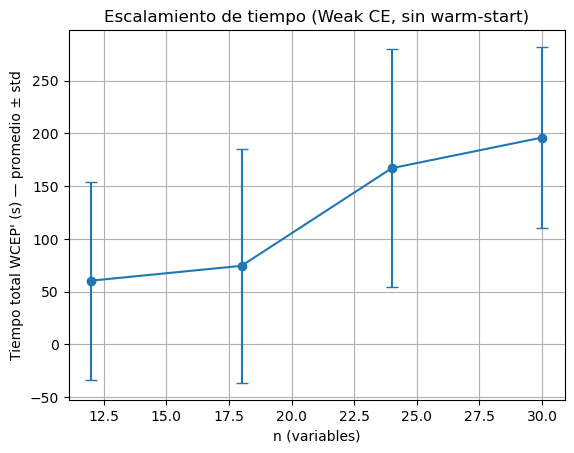

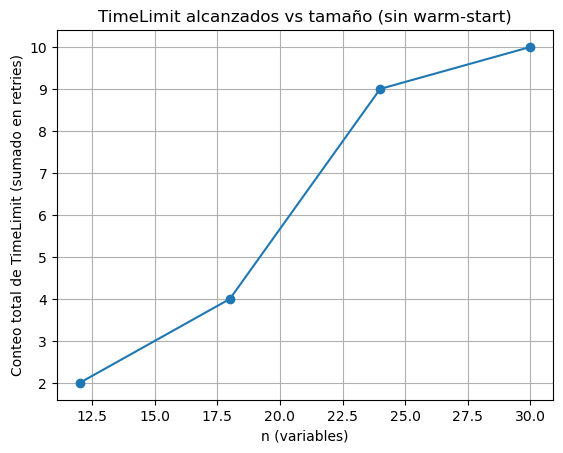

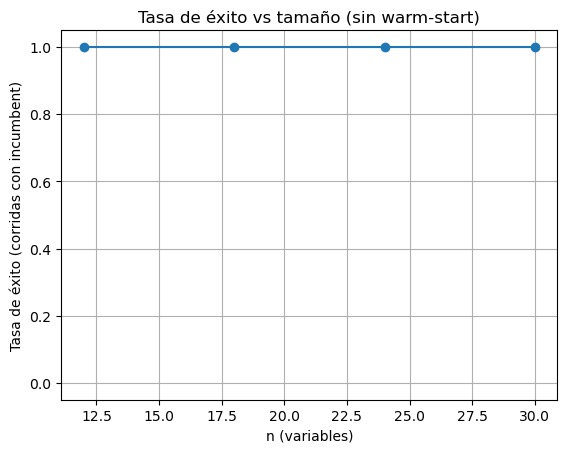

In [19]:
if __name__ == "__main__":
    n_values = [12, 18, 24, 30]
    results = benchmark_wcep_scaling_no_warmstart(
        n_values=n_values,
        runs_per_n=15,
        pct_bounds=0.30,
        time_limit=250.0,
        max_retries=0,
        base_seed=42,
        output=0
    )
    plot_benchmark_results(results)

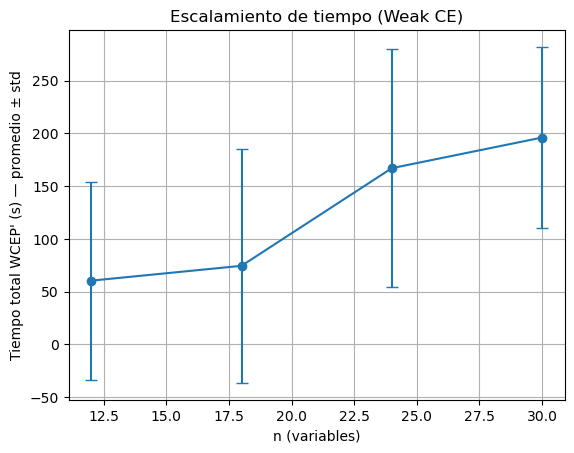

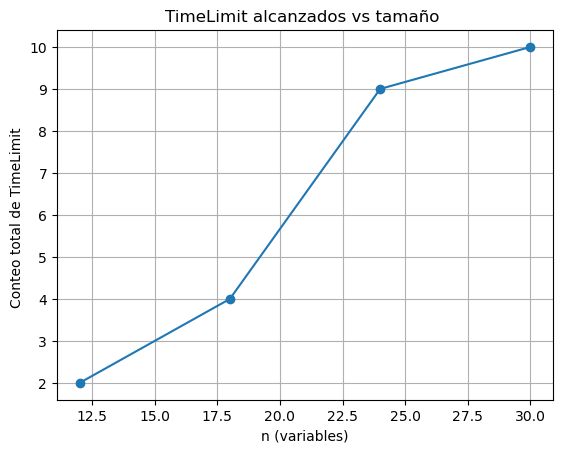

In [22]:
plot_benchmark_results(results)


=== Benchmark n=12, m=4 ===
  run 1/50: total=361.341s attempts=1 timeouts=1 success=True best=TIME_LIMIT obj=0.19332292592583591
  run 2/50: total=3.677s attempts=1 timeouts=0 success=True best=OPTIMAL obj=0.3565481612838419
  run 3/50: total=306.944s attempts=1 timeouts=0 success=True best=OPTIMAL obj=0.21534785875757811
  run 4/50: total=123.269s attempts=1 timeouts=0 success=True best=OPTIMAL obj=0.5943732977033362
  run 5/50: total=1.502s attempts=1 timeouts=0 success=True best=OPTIMAL obj=0.28521692340239846
  run 6/50: total=5.034s attempts=1 timeouts=0 success=True best=OPTIMAL obj=0.24841563964733715
  run 7/50: total=5.637s attempts=1 timeouts=0 success=True best=OPTIMAL obj=0.5184287263773357
  run 8/50: total=1.071s attempts=1 timeouts=0 success=True best=OPTIMAL obj=0.5881408075536827
  run 9/50: total=0.233s attempts=1 timeouts=0 success=True best=OPTIMAL obj=0.47399073902933786
  run 10/50: total=234.064s attempts=1 timeouts=0 success=True best=OPTIMAL obj=0.36527613266

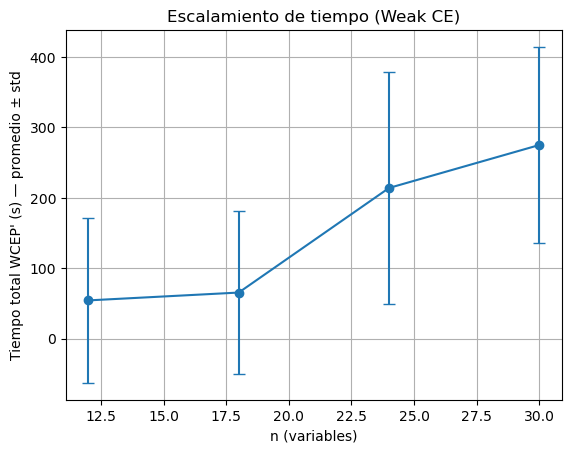

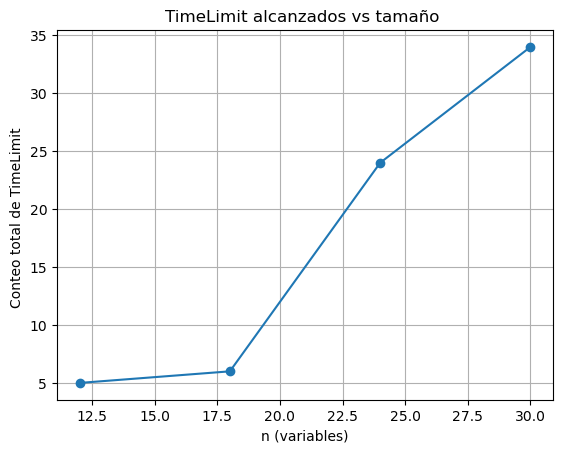

In [23]:
if __name__ == "__main__":
    n_values = [12, 18, 24, 30]
    results = benchmark_wcep_scaling_no_warmstart(
        n_values=n_values,
        runs_per_n=50,
        pct_bounds=0.30,
        time_limit=360.0,
        max_retries=0,
        base_seed=42,
        output=0
    )
    plot_benchmark_results(results)